<a href="https://colab.research.google.com/github/prachi-khandelwal/Dog-Vision-MultiClassification-Project/blob/master/end_to_end_dog_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🐶End-To-End MultiClass Dog Breed Identification

this Notebook builds an end-to-end multi-class image classifier using TensolrFlow 2.0 and Tensorflow Hub.

## 1. Problem

Identifying the breed of the dog given in the image of a dog.

When I am roaming around in my locality a dog passed and I wanted to Know the breed of the dog.😊😁

## 2. Data

The Data we're using is from Kaggle's Dog Breed identification competition.

https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation

The evaluation is the file with Prediction Probabilitiesfor each dog breed in the image.

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation
## 4. Features

Some Information about the Data:
* We're dealing with images (unstructured Data) so its probably best to use Deep learning /Transfer Learning.
* There are 120 breeds of dogs (this means there are 120 different classes).
* There are around 10K images in Trainng set (These Images have Labels).
* There are around 10k images in Test set (These Images don't have labels).





In [23]:
# Unzip the data into Google Drive.
# !unzip "/content/drive/My Drive/Dog vision/dog-breed-identification.zip" -d "drive/My Drive/Dog vision"

# Get our Workspace Ready!
* Import Tensorflow 2.x ✅
* Import TensorFlow Hub✅
* Make sure we're using a GPU 


Import necessary Tools

In [24]:
# Import TensorFlow into COlAB
import tensorflow as tf
print("Tensorflow version:",tf.__version__)
# Import Tensorflow HUB
import tensorflow_hub as hub
print("Tensorflow hub version:",hub.__version__)

Tensorflow version: 2.2.0
Tensorflow hub version: 0.8.0


In [25]:
# Check If a GPU available
print("GPU", "available Hurray !!!" if tf.config.list_physical_devices("GPU") else "not available :(")

GPU available Hurray !!!


## Getting our Data ready! (turning into tensors)
With all ML models our data must be in numerical format. So that's what we're going to do.
Turning our images into tensors(Numerical Representation)

Let's start by accessing our data and checking labels



In [27]:
# Checkout the data labels
import pandas as pd
import numpy as np
labels_csv = pd.read_csv("drive/My Drive/Dog vision/labels.csv")
print(labels_csv.describe())
labels_csv.head()

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     cfb9775c071c3c447d1e7f132bc5b48e  scottish_deerhound
freq                                   1                 126


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [29]:
labels_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB


In [30]:
# Let's see the no. of images of each breed
labels_csv["breed"].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
brabancon_griffon        67
golden_retriever         67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

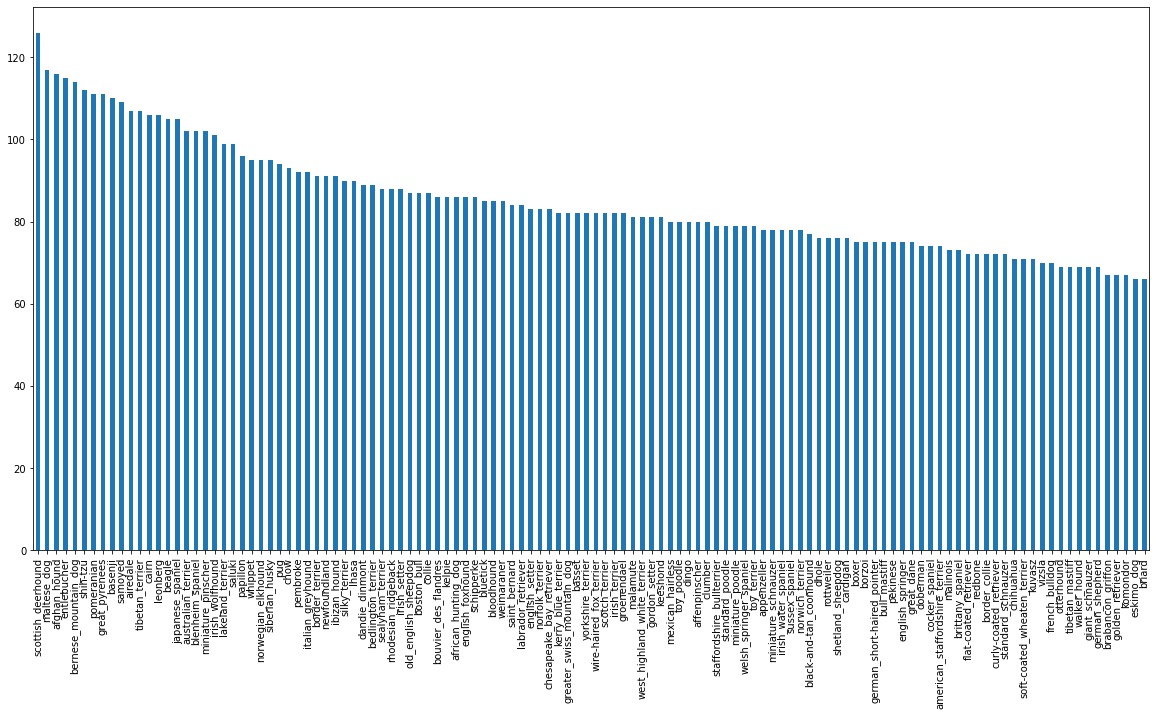

In [31]:
# let's visualize it
ax = labels_csv["breed"].value_counts().plot.bar(figsize=(20,10));
# mean_line, median_line = np.mean(labeles_csv["breed"].value_counts()), np.median(labeles_csv["breed"].value_counts())
# mean_line, median_line
# axvline(mean_line, color='r', linestyle='--')

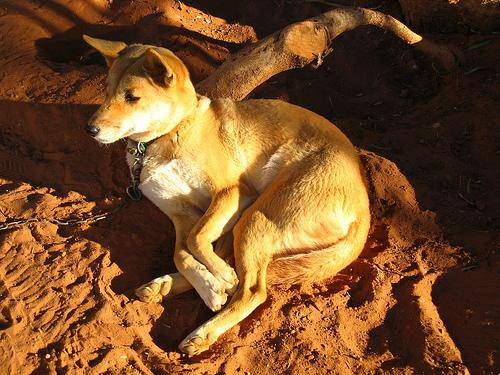

In [38]:
# To display the Images
from IPython.display import display, Image
Image("drive/My Drive/Dog vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

## Getting Images and their labels
Let's get list of our images file Pathnames

In [39]:

# Create filenames from ID
filenames = ["drive/My Drive/Dog vision/train/" + fname + ".jpg" for fname in labels_csv["id"]]
filenames[:10]

['drive/My Drive/Dog vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/Dog vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/Dog vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/Dog vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/Dog vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/Dog vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/Dog vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/Dog vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/Dog vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/Dog vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [47]:
# Checking whether the number of filenames mathcing to the actual images files in train folder
import os
if len(os.listdir("drive/My Drive/Dog vision/train/")) == len(filenames):
  print("Number of files Matched Proceed!")
else:
  print("Files Not Matched Errrorr!")
  
  

Files Not Matched Errrorr!


In [46]:
#one more dog
print(len("/content/drive/My Drive/Dog vision/train"))

40


In [ ]:
Image(filenames[2000])
